# Diffvg painterly rendering
### With different loss functions
### Based on CLIPDraw

This Colab notebook is adapted by **Florian Nolte** from CLIPDraw (Kevin Frans, L.B. Soros, Olaf Witkowski): [CLIPDraw: Exploring Text-to-Drawing Synthesis through Language-Image Encoders](https://arxiv.org/abs/2106.14843) 

Rendereing code adapted from diffvg: https://github.com/BachiLi/diffvg/blob/master/apps/painterly_rendering.py


CLIPDRaw blog post: [https://kvfrans.com/clipdraw-exploring-text-to-drawing-synthesis/](https://kvfrans.com/clipdraw-exploring-text-to-drawing-synthesis/)

--- 


**STEPS:**

INSTALLATION AND SETUP
0. 
  1. Click "Connect" in the top right corner
  2. Runtime -> Change runtime type -> Hardware accelerator -> GPU
  2. Click the run button on "Pre Installation". This will install dependencies, it may take a while.
  3. **Important:** Runtime -> Restart Runtime
  4. You can now run the notebook cells
1.  These cells are imports and utilities, needed for training and curve optimization
2. Load the CLIP model. This only works on GPU!
3. Training of custom stroke loss. This can be completely skipped if you only want to use the curve optimizer with other losses
4. Curve optimizer to paint images with different loss functions

In [ ]:
#@title 0. Pre Installation {vertical-output: true}

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
%cd /content/
!pip install svgwrite
!pip install svgpathtools
!pip install cssutils
!pip install numba
!pip install torch-tools
!pip install visdom

!git clone https://github.com/BachiLi/diffvg
%cd diffvg
# !ls
!git submodule update --init --recursive

data = []
with open("/content/diffvg/CMakeLists.txt", "r+") as inFile:
    for line in inFile:
        if "find_package(TensorFlow)" in line:
            pass
        else:
            data.append(line)
    inFile.seek(0)
    for d in data:
        inFile.write(d)
    inFile.truncate()
!python setup.py install

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git --no-deps

CUDA version: 11.2
/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 983 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 399 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 1.4 MB 30.0 MB/s 
     |████████████████████████████████| 26.9 MB 9.7 MB/s 
     |████████████████████████████████| 86 kB 3.9 MB/s 
     |██████████████████

In [ ]:
#@title 1. Imports and Notebook Utilities {vertical-output: true}
from __future__ import print_function
from __future__ import division

%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

#######

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from google.colab import files

import pydiffvg
import diffvg

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

from skimage import exposure
import torch

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

import numpy as np
import torch
import os

import pydiffvg
import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn

import torchvision.transforms as T

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

pydiffvg.set_use_gpu(torch.cuda.is_available())

!pip install torchmetrics[image]
!pip install lpips

import torchmetrics
import lpips

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

from torchmetrics.functional import structural_similarity_index_measure, multiscale_structural_similarity_index_measure, peak_signal_noise_ratio,universal_image_quality_index
#######

model_ft = None

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img = img.resize((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

from torchvision import utils
def show_img(img, size = (7,7)):
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    img = np.uint8(img * 254)
    # img = np.repeat(img, 4, axis=0)
    # img = np.repeat(img, 4, axis=1)
    pimg = PIL.Image.fromarray(img, mode="RGB")
    imshow(pimg)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

import numpy as np
import torch
import os

# torch.set_default_tensor_type('torch.cuda.FloatTensor')

print("Torch version:", torch.__version__)

# !pip install DALL-E

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 14.5 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
GPU 0: Tesla T4 (UUID: GPU-8ffadcc4-5a70-f60a-facc-d052686d9b96)
Torch version: 1.12.1+cu113


In [ ]:
#@title 2. Load CLIP for text visualization {vertical-output: true}
#@markdown For joint optimization of reference text and images
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import os
import clip
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Load the model
device = torch.device('cuda')
model, preprocess = clip.load('ViT-B/32', device, jit=False)

nouns = "aardvark abyssinian accelerator accordion account accountant acknowledgment acoustic acrylic act action active activity actor actress adapter addition address adjustment adult advantage advertisement advice afghanistan africa aftermath afternoon aftershave afterthought age agenda agreement air airbus airmail airplane airport airship alarm albatross alcohol algebra algeria alibi alley alligator alloy almanac alphabet alto aluminium aluminum ambulance america amount amusement anatomy anethesiologist anger angle angora animal anime ankle answer ant antarctica anteater antelope anthony anthropology apartment apology apparatus apparel appeal appendix apple appliance approval april aquarius arch archaeology archeology archer architecture area argentina argument aries arithmetic arm armadillo armchair armenian army arrow art ash ashtray asia asparagus asphalt asterisk astronomy athlete atm atom attack attempt attention attic attraction august aunt australia australian author authorisation authority authorization avenue babies baboon baby back backbone bacon badge badger bag bagel bagpipe bail bait baker bakery balance balinese ball balloon bamboo banana band bandana bangladesh bangle banjo bank bankbook banker bar barbara barber barge baritone barometer base baseball basement basin basket basketball bass bassoon bat bath bathroom bathtub battery battle bay beach bead beam bean bear beard beast beat beautician beauty beaver bed bedroom bee beech beef beer beet beetle beggar beginner begonia behavior belgian belief believe bell belt bench bengal beret berry bestseller betty bibliography bicycle bike bill billboard biology biplane birch bird birth birthday bit bite black bladder blade blanket blinker blizzard block blood blouse blow blowgun blue board boat bobcat body bolt bomb bomber bone bongo bonsai book bookcase booklet boot border botany bottle bottom boundary bow bowl bowling box boy bra brace bracket brain brake branch brand brandy brass brazil bread break breakfast breath brian brick bridge british broccoli brochure broker bronze brother brother-in-law brow brown brush bubble bucket budget buffer buffet bugle building bulb bull bulldozer bumper bun burglar burma burn burst bus bush business butane butcher butter button buzzard cabbage cabinet cable cactus cafe cake calculator calculus calendar calf call camel camera camp can canada canadian cancer candle cannon canoe canvas cap capital cappelletti capricorn captain caption car caravan carbon card cardboard cardigan care carnation carol carp carpenter carriage carrot cart cartoon case cast castanet cat catamaran caterpillar cathedral catsup cattle cauliflower cause caution cave c-clamp cd ceiling celery celeste cell cellar cello celsius cement cemetery cent centimeter century ceramic cereal certification chain chair chalk chance change channel character chard charles chauffeur check cheek cheese cheetah chef chemistry cheque cherries cherry chess chest chick chicken chicory chief child children chill chime chimpanzee chin china chinese chive chocolate chord christmas christopher chronometer church cicada cinema circle circulation cirrus citizenship city clam clarinet class claus clave clef clerk click client climb clipper cloakroom clock close closet cloth cloud cloudy clover club clutch coach coal coast coat cobweb cockroach cocktail cocoa cod coffee coil coin coke cold collar college collision colombia colon colony color colt column columnist comb comfort comic comma command commission committee community company comparison competition competitor composer composition computer condition condor cone confirmation conga congo conifer connection consonant continent control cook cooking copper copy copyright cord cork cormorant corn cornet correspondent cost cotton couch cougar cough country course court cousin cover cow cowbell crab crack cracker craftsman crate crawdad crayfish crayon cream creator creature credit creditor creek crib cricket crime criminal crocodile crocus croissant crook crop cross crow crowd crown crush cry cub cuban cucumber cultivator cup cupboard cupcake curler currency current curtain curve cushion custard customer cut cuticle cycle cyclone cylinder cymbal dad daffodil dahlia daisy damage dance dancer danger daniel dash dashboard database date daughter david day dead deadline deal death deborah debt debtor decade december decimal decision decrease dedication deer defense deficit degree delete delivery den denim dentist deodorant department deposit description desert design desire desk dessert destruction detail detective development dew diamond diaphragm dibble dictionary dietician difference digestion digger digital dill dime dimple dinghy dinner dinosaur diploma dipstick direction dirt disadvantage discovery discussion disease disgust dish distance distribution distributor diving division divorced dock doctor dog dogsled doll dollar dolphin domain donald donkey donna door dorothy double doubt downtown dragon dragonfly drain drake drama draw drawbridge drawer dream dredger dress dresser dressing drill drink drive driver driving drizzle drop drug drum dry dryer duck duckling dugout dungeon dust eagle ear earth earthquake ease east edge edger editor editorial education edward eel effect egg eggnog eggplant egypt eight elbow element elephant elizabeth ellipse emery employee employer encyclopedia end enemy energy engine engineer engineering english enquiry entrance environment epoch epoxy equinox equipment era error estimate ethernet ethiopia euphonium europe evening event examination example exchange exclamation exhaust ex-husband existence expansion experience expert explanation ex-wife eye eyebrow eyelash eyeliner face facilities fact factory fahrenheit fairies fall family fan fang farm farmer fat father father-in-law faucet fear feast feather feature february fedelini feedback feeling feet felony female fender ferry ferryboat fertilizer fiber fiberglass fibre fiction field fifth fight fighter file find fine finger fir fire fired fireman fireplace firewall fish fisherman flag flame flare flat flavor flax flesh flight flock flood floor flower flugelhorn flute fly foam fog fold font food foot football footnote force forecast forehead forest forgery fork form format fortnight foundation fountain fowl fox foxglove fragrance frame france freckle freeze freezer freighter french freon friction friday fridge friend frog front frost frown fruit fuel fur furniture galley gallon game gander garage garden garlic gas gasoline gate gateway gauge gazelle gear gearshift geese gemini gender geography geology geometry george geranium german germany ghana ghost giant giraffe girdle girl gladiolus glass glider gliding glockenspiel glove glue goal goat gold goldfish golf gondola gong good-bye goose gore-tex gorilla gosling government governor grade grain gram granddaughter grandfather grandmother grandson grape graphic grass grasshopper gray grease great-grandfather great-grandmother greece greek green grenade grey grill grip ground group grouse growth guarantee guatemalan guide guilty guitar gum gun gym gymnast hacksaw hail hair haircut half-brother half-sister halibut hall hallway hamburger hammer hamster hand handball handicap handle handsaw harbor hardboard hardcover hardhat hardware harmonica harmony harp hat hate hawk head headlight headline health hearing heart heat heaven hedge height helen helicopter helium hell helmet help hemp hen heron herring hexagon hill himalayan hip hippopotamus history hobbies hockey hoe hole holiday home honey hood hook hope horn horse hose hospital hot hour hourglass house hovercraft hub hubcap humidity humor hurricane hyacinth hydrant hydrofoil hydrogen hyena hygienic ice icebreaker icicle icon idea ikebana illegal imprisonment improvement impulse inch income increase index india indonesia industry ink innocent input insect instruction instrument insulation insurance interactive interest internet interviewer intestine invention inventory invoice iran iraq iris iron island israel italian italy jacket jaguar jail jam james january japan japanese jar jasmine jason jaw jeans jeep jeff jelly jellyfish jennifer jet jewel jogging john join joke joseph journey judge judo juice july jumbo jump jumper june jury justice jute kale kamikaze kangaroo karate karen kayak kendo kenneth kenya ketchup kettle kettledrum kevin key keyboard keyboarding kick kidney kilogram kilometer kimberly kiss kitchen kite kitten kitty knee knickers knife knight knot knowledge kohlrabi korean laborer lace ladybug lake lamb lamp lan land landmine language larch lasagna latency latex lathe laugh laundry laura law lawyer layer lead leaf learning leather leek leg legal lemonade lentil leo leopard letter lettuce level libra library license lier lift light lightning lilac lily limit linda line linen link lion lip lipstick liquid liquor lisa list literature litter liver lizard llama loaf loan lobster lock locket locust look loss lotion love low lumber lunch lunchroom lung lunge lute luttuce lycra lynx lyocell lyre lyric macaroni machine macrame magazine magic magician maid mail mailbox mailman makeup malaysia male mall mallet man manager mandolin manicure manx map maple maraca marble march margaret margin maria marimba mark mark market married mary mascara mask mass match math mattock may mayonnaise meal measure meat mechanic medicine meeting melody memory men menu mercury message metal meteorology meter methane mexican mexico mice michael michelle microwave middle mile milk milkshake millennium millimeter millisecond mimosa mind mine minibus mini-skirt minister mint minute mirror missile mist mistake mitten moat modem mole mom monday money monkey month moon morning morocco mosque mosquito mother mother-in-law motion motorboat motorcycle mountain mouse moustache mouth move multi-hop multimedia muscle museum music musician mustard myanmar nail name nancy napkin narcissus nation neck need needle neon nepal nephew nerve nest net network news newsprint newsstand nic nickel niece nigeria night nitrogen node noise noodle north north america north korea norwegian nose note notebook notify novel november number numeric nurse nut nylon oak oatmeal objective oboe observation occupation ocean ocelot octagon octave october octopus odometer offence offer office oil okra olive onion open opera operation ophthalmologist opinion option orange orchestra orchid order organ organisation organization ornament ostrich otter ounce output outrigger oval oven overcoat owl owner ox oxygen oyster package packet page pail pain paint pair pajama pakistan palm pamphlet pan pancake pancreas panda pansy panther panties pantry pants panty pantyhose paper paperback parade parallelogram parcel parent parentheses park parrot parsnip part particle partner partridge party passbook passenger passive pasta paste pastor pastry patch path patient patio patricia paul payment pea peace peak peanut pear pedestrian pediatrician peen peer-to-peer pelican pen penalty pencil pendulum pentagon peony pepper perch perfume period periodical peripheral permission persian person peru pest pet pharmacist pheasant philippines philosophy phone physician piano piccolo pickle picture pie pig pigeon pike pillow pilot pimple pin pine ping pink pint pipe pisces pizza place plain plane planet plant plantation plaster plasterboard plastic plate platinum play playground playroom pleasure plier plot plough plow plywood pocket poet point poison poland police policeman polish politician pollution polo polyester pond popcorn poppy population porch porcupine port porter position possibility postage postbox pot potato poultry pound powder power precipitation preface prepared pressure price priest print printer prison probation process processing produce product production professor profit promotion propane property prose prosecution protest protocol pruner psychiatrist psychology ptarmigan puffin pull puma pump pumpkin punch punishment puppy purchase purple purpose push pvc pyjama pyramid quail quality quart quarter quartz queen question quicksand quiet quill quilt quince quit quiver quotation rabbi rabbit racing radar radiator radio radish raft rail railway rain rainbow raincoat rainstorm rake ramie random range rat rate raven ravioli ray rayon reaction reading reason receipt recess record recorder rectangle red reduction refrigerator refund regret reindeer relation relative religion relish reminder repair replace report representative request resolution respect responsibility rest restaurant result retailer revolve revolver reward rhinoceros rhythm rice richard riddle rifle ring rise risk river riverbed road roadway roast robert robin rock rocket rod roll romania romanian ronald roof room rooster root rose rotate route router rowboat rub rubber rugby rule run russia russian rutabaga ruth sack sagittarius sail sailboat sailor salad salary sale salesman salmon salt sampan samurai sand sandra sandwich santa sarah sardine satin saturday sauce saudi arabia sausage save saw saxophone scale scallion scanner scarecrow scarf scene scent schedule school science scissors scooter scorpio scorpion scraper screen screw screwdriver sea seagull seal seaplane search seashore season seat second secretary secure security seed seeder segment select selection self semicircle semicolon sense sentence separated september servant server session sex shade shadow shake shallot shame shampoo shape share shark sharon shears sheep sheet shelf shell shield shingle ship shirt shock shoe shoemaker shop shorts shoulder shovel show shrimp shrine siamese siberian side sideboard sidecar sidewalk sign signature silica silk silver sing singer single sink sister sister-in-law size skate skiing skill skin skirt sky slash slave sled sleep sleet slice slime slip slipper slope smash smell smile smoke snail snake sneeze snow snowboarding snowflake snowman snowplow snowstorm soap soccer society sociology sock soda sofa softball softdrink software soil soldier son song soprano sort sound soup sousaphone south africa south america south korea soy soybean space spade spaghetti spain spandex spark sparrow spear specialist speedboat sphere sphynx spider spike spinach spleen sponge spoon spot spring sprout spruce spy square squash squid squirrel stage staircase stamp star start starter state statement station statistic steam steel stem step step-aunt step-brother stepdaughter step-daughter step-father step-grandfather step-grandmother stepmother step-mother step-sister stepson step-son step-uncle steven stew stick stinger stitch stock stocking stomach stone stool stop stopsign stopwatch store storm story stove stranger straw stream street streetcar stretch string structure study sturgeon submarine substance subway success sudan suede sugar suggestion suit summer sun sunday sundial sunflower sunshine supermarket supply support surfboard surgeon surname surprise susan sushi swallow swamp swan sweater sweatshirt sweatshop swedish sweets swim swimming swing swiss switch sword swordfish sycamore syria syrup system table tablecloth tabletop tachometer tadpole tail tailor taiwan talk tank tanker tanzania target taste taurus tax taxi taxicab tea teacher teaching team technician teeth television teller temper temperature temple tempo tendency tennis tenor tent territory test text textbook texture thailand theater theory thermometer thing thistle thomas thought thread thrill throat throne thumb thunder thunderstorm thursday ticket tie tiger tights tile timbale time timer timpani tin tip tire titanium title toad toast toe toenail toilet tomato tom-tom ton tongue tooth toothbrush toothpaste top tornado tortellini tortoise touch tower town toy tractor trade traffic trail train tramp transaction transmission transport trapezoid tray treatment tree trial triangle trick trigonometry trip trombone trouble trousers trout trowel truck trumpet trunk t-shirt tsunami tub tuba tuesday tugboat tulip tuna tune turkey turkey turkish turn turnip turnover turret turtle tv twig twilight twine twist typhoon tyvek uganda ukraine ukrainian umbrella uncle underclothes underpants undershirt underwear unit united kingdom unshielded use utensil uzbekistan vacation vacuum valley value van vase vault vegetable vegetarian veil vein velvet venezuela venezuelan verdict vermicelli verse vessel vest veterinarian vibraphone vietnam view vinyl viola violet violin virgo viscose vise vision visitor voice volcano volleyball voyage vulture waiter waitress walk wall wallaby wallet walrus war warm wash washer wasp waste watch watchmaker water waterfall wave wax way wealth weapon weasel weather wedge wednesday weed weeder week weight whale wheel whip whiskey whistle white wholesaler whorl wilderness william willow wind windchime window windscreen windshield wine wing winter wire wish witch withdrawal witness wolf woman women wood wool woolen word work workshop worm wound wrecker wren wrench wrinkle wrist writer xylophone yacht yak yam yard yarn year yellow yew yogurt yoke yugoslavian zebra zephyr zinc zipper zone zoo zoology"
nouns = nouns.split(" ")
noun_prompts = ["a drawing of a " + x for x in nouns]

# Calculate features
with torch.no_grad():
    nouns_features = model.encode_text(torch.cat([clip.tokenize(noun_prompts).to(device)]))
print(nouns_features.shape, nouns_features.dtype)


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 198MiB/s]


torch.Size([2343, 512]) torch.float16


## 3. Training a parameter-distance-based perceptual loss
### Skip 3. and go to 4. if you only want to use the regular Diffvg / CLIPDraw optimizer


In [ ]:
# Hyperparameters of model training

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# size of embedding vector used for image distance
embedding_size = 100

# Batch size for training 
batch_size = 8

# Number of epochs to train for
num_epochs = 10

# You can try out a pre-trained model. The download link is in the cell below
load_model = True

# when training a model, you can start with a pre-trained model 
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False



In [ ]:
# load model
!gdown --id {'1ryG5YD-P7mbFv2Rq0tl_JIqrfGdZCGyU'}
checkpoint_path = '/content/checkpoint_dual_resnet_20strokes10.pth'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ryG5YD-P7mbFv2Rq0tl_JIqrfGdZCGyU
To: /content/diffvg/apps/checkpoint_dual_resnet_20strokes10.pth
100% 45.0M/45.0M [00:00<00:00, 107MB/s]


In [ ]:
# Helper functions for rendering


def params_to_rectangle_shapes(parameters, ellipse = False):
    '''
    Helper function to calculate diffvg shapes and shapegroups from parameter vector
    [x0, y0, x1, y1, width, r, g, b, alpha] * num_strokes
    We call the strokes rectangles here, but in reality they are more similar to line segments.
    '''
    #print(parameters.shape, type(parameters))
    rectangles = parameters.view((-1, 9)) # because 9 parameters per rectangle
    shape_groups = []
    shapes = []

    for stroke in rectangles:
        # no control points -> not curved strokes
        num_segments = torch.tensor([1.0])
        num_control_points = torch.tensor([0])

        # get position parameters
        points = stroke[0:4].reshape(2,2)
        if torch.sum(torch.abs(points[0] - points[1])).item() < 0.05: # if points had a distance of 0.0, the renderer would crash
            points[0] += torch.tensor((0.05, 0.05))
        
        # generate strokes
        path = pydiffvg.Path(num_control_points = num_control_points, points = points, stroke_width = stroke[4], is_closed = False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]), fill_color = None, stroke_color = stroke[5:9])
        shape_groups.append(path_group)
          
    return shapes, shape_groups

def render_shapes(shapes, shape_groups, height=128, width=128, quality=2, show_plot = False):
    '''Render shapes and shapegroups. If show_plot is True, it will plot the shapes instead of returning the pixel array.'''

    # arbitrary internal scale which the shape params have to be based on. Can be equal to pixels, but does not have to.
    canvas_width = torch.tensor([1.0]) 
    canvas_height = torch.tensor([1.0])
    
    scene_args = pydiffvg.RenderFunction.serialize_scene(canvas_width,
                                                         canvas_height,
                                                         shapes,
                                                         shape_groups,)
                                                         #filter = pydiffvg.PixelFilter(type = diffvg.FilterType.hann, radius = torch.tensor(8.0)))
    
    # render scene
    # cannot be used as kw-args!
    render = pydiffvg.RenderFunction.apply
    img = render(width, # render pixel width
                 height, # render pixel height
                 quality, # num_samples_x - seems to increase render time quadratically or exponentially
                 quality, # num_samples_y
                 random.randint(0, 1048576), # seed
                 torch.ones((width, height, 4),requires_grad=True), # background_image
                 *scene_args) # all shapes, etc.
    
    #img = img / 256 # needed for sdf
    # apply gamma correction - does not seem to be terribly important
    # img = exposure.adjust_gamma(img.detach().cpu().numpy(), 1)
    
    
    # remove alpha channel
    #img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    
    # Permute for pytorch
    #img = img.unsqueeze(0)
    #img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    if show_plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(img.detach().cpu())
    
    else:
        return img

### Artificial stroke dataset

In [ ]:
class RectangleDataset(Dataset):
    # todo: only supply parameters in init, with which the getitem funciton can create the dataset on the fly
    def __init__(self, min_n_shapes, max_n_shapes, max_stepsize, img_size, transform=None, target_transform=None, size = 3200):
        """parameter boundaries: two lists: minimum and maximum values for parameters"""
        self.img_size = img_size
        self.transform = transform
        self.target_transform = target_transform
        self.max_n_shapes = max_n_shapes
        self.min_n_shapes = min_n_shapes
        self.max_stepsize = max_stepsize
        self.size = size
        self.blur = torchvision.transforms.GaussianBlur(5, sigma=(0.1, 4.0))
    def __len__(self):
        return self.size # does not matter because it is self generated

    def __getitem__(self, idx):
        with torch.no_grad():
            # possible additions:
            # - blur images
            # - increase max_stepsize over the course of training
            # - increase number of shapes over training
            # 

            # number of shapes to be rendered
            min_n_shapes = self.min_n_shapes
            max_n_shapes = self.max_n_shapes
            n_shapes = torch.distributions.categorical.Categorical(torch.tensor([1.0]*(max_n_shapes - min_n_shapes + 1))).sample() + min_n_shapes
            n_background_strokes = 4
            
            n_diffusion_steps = 10 # together with diffusion stepsize controls magnitude of diffusion
            
            stepsize = torch.rand(1) * self.max_stepsize
            
            select_diffusion = torch.rand(1).item()
            # only color change
            if 0 <= select_diffusion < 0.25:
              diffusion_stepsizes = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.001, 1, 1, 1, 1]) * stepsize
            
            # only position change
            if 0.25 <= select_diffusion < 0.5:
              diffusion_stepsizes = torch.tensor([1, 1, 1, 1, 1, 0.001, 0.01, 0.01, 0.01]) * stepsize
            
            # color and position changes
            if 0.5 <= select_diffusion <= 1:
              diffusion_stepsizes = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]) * stepsize


            #diffusion_stepsizes = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1]) * stepsize
            #diffusion_stepsizes = torch.tensor([1  , 1  , 1  , 1  , 1  , 1, 1, 1, 1]) * stepsize # stepsizes for every parameter: [angle, x, y, width, height, r, g, b, a]
            strokes_diffused = []
            strokes_init = []
            
            # scale all rectangles to be in similar parameter range (to have some datapoints where all rectangles are small)
            scale = 0.5 + torch.rand(1)
            scale = 0.5

            # for strokes
            min_values = torch.tensor([0.1,0.1,0.1,0.1,0.02,0,0,0,0.2]) # x1, y1, x2, y2, w, r, g, b, a
            max_values = torch.tensor([0.9,0.9,0.9,0.9,0.15*scale,1,1,1,1])
            
            short_strokes = torch.rand(1).item() > 0.8

            for stroke in range(n_shapes):
                if short_strokes:
                    position = torch.rand(2)
                    size = (torch.rand(2) - 0.5) * 0.3
                    width = torch.rand(1) #* 0.15
                    color = torch.rand(4)
                    params = torch.cat([position, position+size, width, color])
                else:
                    params = torch.rand(9)
                params = params * (max_values - min_values) + min_values
                strokes_init.append(params)
                for step in range(n_diffusion_steps):
                    params = params + torch.distributions.normal.Normal(torch.tensor([0.0]*9), diffusion_stepsizes).sample()
                    params = params.clip(min=min_values, max=max_values)
                strokes_diffused.append(params)

            if torch.rand(1)[0].item() > 0.5: # choose between rectangles and ellipses
              shapes, shape_groups = params_to_rectangle_shapes(torch.cat(strokes_init))
              img_init = render_shapes(shapes, shape_groups, height=self.img_size, width = self.img_size, quality=2)

              shapes, shape_groups = params_to_rectangle_shapes(torch.cat(strokes_diffused))
              img_diffused = render_shapes(shapes, shape_groups, height=self.img_size, width = self.img_size, quality=2)
            
            else:
              shapes, shape_groups = params_to_rectangle_shapes(torch.cat(strokes_init), ellipse = True)
              img_init = render_shapes(shapes, shape_groups, height=self.img_size, width = self.img_size, quality=2)

              shapes, shape_groups = params_to_rectangle_shapes(torch.cat(strokes_diffused), ellipse = True)
              img_diffused = render_shapes(shapes, shape_groups, height=self.img_size, width = self.img_size, quality=2)

            img_diffused = img_diffused[:, :, 3:4] * img_diffused[:, :, :3] + torch.ones(img_diffused.shape[0], img_diffused.shape[1], 3, device = pydiffvg.get_device()) * (1 - img_diffused[:, :, 3:4])
            img_diffused = img_diffused[:, :, :3]
            #img_diffused = img_diffused.unsqueeze(0)
            img_diffused = img_diffused.permute(2,0,1) # NHWC -> NCHW

            img_init = img_init[:, :, 3:4] * img_init[:, :, :3] + torch.ones(img_init.shape[0], img_init.shape[1], 3, device = pydiffvg.get_device()) * (1 - img_init[:, :, 3:4])
            img_init = img_init[:, :, :3]
            #img_init = img_init.unsqueeze(0)
            img_init = img_init.permute(2, 0, 1) # NHWC -> NCHW

            # sometimes add small blur to target image
            if torch.rand(1).item() > 0.5:
              img_init = self.blur(img_init)
              img_diffused = self.blur(img_diffused)

            # euclidean
            #distance = torch.mean(torch.abs(torch.cat(strokes_init) - torch.cat(strokes_diffused))**1) # not sure if mean or sum and L1 or L2 makes more sense
            distance = torch.sum(torch.abs(torch.cat(strokes_init) - torch.cat(strokes_diffused))) # not sure if mean or sum and L1 or L2 makes more sense

            if self.transform:
                img_init = self.transform(img_init)
                img_diffused = self.transform(img_diffused)
            if self.target_transform:
                params = self.target_transform(params)
            
            return torch.cat([img_diffused, img_init], dim = 0), distance

tensor(3.7927)


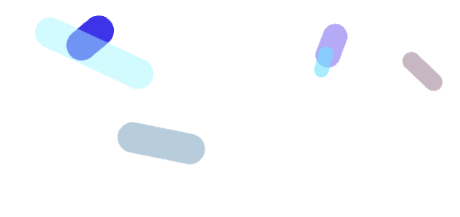

In [ ]:
# Visualize some results of dataset

# [angle, x, y, width, height, r, g, b, a]

dataset_train = RectangleDataset(min_n_shapes = 1, max_n_shapes = 20, max_stepsize = 0.2, img_size = 224)
dataset_test = RectangleDataset(min_n_shapes = 1, max_n_shapes = 20, max_stepsize = 0.2, img_size = 224)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


X, y = next(iter(train_dataloader))

fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(X[0][:3].permute(1,2,0).cpu())
axs[1].imshow(X[0][3:6].permute(1,2,0).cpu())
axs[0].axis("off")
axs[1].axis("off")
print(y[0])


### Training

Train (or fine-tune pre-trained) vision model to learn distance value. Code adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, two_networks = True):
    since = time.time()

    val_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_mean = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        if two_networks:
                          embeddings_1 = model(inputs[:,0:3,:,:])
                          embeddings_2 = model(inputs[:,3:6,:,:])
                          embedding_distances = torch.sum((embeddings_1 - embeddings_2)**2, dim=1)
                          loss = torch.sum((embedding_distances - labels)**2)
                          loss_mean = torch.mean(torch.abs(embedding_distances - labels))
                        else: # regular prediction loss, expects different model architecture!
                          outputs = model(inputs)
                          loss = criterion(outputs.squeeze(1), labels)

                    #_, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_loss_mean += loss_mean.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = running_loss_mean / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc < best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            else:
                train_loss_history.append(epoch_loss)
            
            #if epoch % 1 == 0:
            #      torch.save(model_ft.state_dict(), 'checkpoint.pth')
            #      files.download('checkpoint.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        #
        #model_ft.conv1 = nn.Conv2d(6,64,kernel_size=(7,7), stride = (2,2), padding = (3,3), bias = False)
        #
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
        #
        model_ft.features[0] = nn.Conv2d(6, 96, kernel_size=(7, 7), stride=(2, 2))
        model_ft.classifier[2] = nn.LeakyReLU(inplace=True)
        #
    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        #
        model_ft.conv0 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

num_classes = embedding_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "

  warnings.warn(msg)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
data_transforms = transforms.Compose([
        #transforms.RandomResizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        #transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# max_stepsize influences the stepsize of random changes to parameter values. Large stepsize = higher distances of images
dataset_train = RectangleDataset(min_n_shapes = 1, max_n_shapes = 20, max_stepsize = 0.15, img_size = input_size, transform = data_transforms, size = 3200)  
dataset_test = RectangleDataset(min_n_shapes = 1, max_n_shapes = 20, max_stepsize = 0.15, img_size = input_size, transform = data_transforms, size = 300)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

dataloaders_dict = {"train": train_dataloader, "val": test_dataloader}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            pass
# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.003)

Params to learn:


In [ ]:
# TRAIN

# Setup the loss fxn
criterion = nn.MSELoss() # how embeddings are compared. e.g. cosine distance would work as well.

if not load_model:
  # Train and evaluate
  model_ft, hist_val, hist_train = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

else:
  state_dict = torch.load(checkpoint_path ,map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
  model_ft.load_state_dict(state_dict)

### Evaluating the model performance

In [ ]:
def diffusion_distance(X):
  embeddings_1 = model_ft(X[:,0:3,:,:])
  embeddings_2 = model_ft(X[:,3:6,:,:])
  embedding_distances = torch.sum((embeddings_1 - embeddings_2)**2, dim=1)
  return embedding_distances

In [ ]:
with torch.no_grad():
  model_ft.eval()
  all_predictions = []
  all_real = []
  dataset = RectangleDataset(min_n_shapes = 1, max_n_shapes = 20, max_stepsize = 0.15, img_size = input_size, transform = data_transforms, size = 2000)
  dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  for (X, y) in dataloader:
    predictions = diffusion_distance(X)
    all_predictions.append(predictions)
    all_real.append(y)

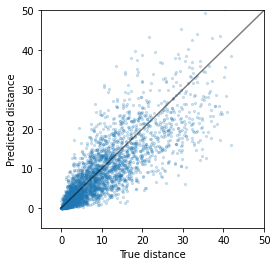

In [ ]:
  plt.figure(figsize=(4,4))
  plt.xlim(-5, 50)
  plt.ylim(-5, 50)
  plt.xlabel("True distance")
  plt.ylabel("Predicted distance")
  real = torch.cat(all_real).cpu()
  pred = torch.cat(all_predictions).cpu()
  plt.scatter(real, pred, alpha = 0.2, s = 5, )
  plt.plot([0,50],[0,50], c = "black", alpha=0.5)
  #plt.savefig("loss_dual.pdf")

In [ ]:
# Mean absolute error of the model
print("MAE: ", torch.mean(torch.abs((real-pred))).item())

MAE:  3.4779043197631836


In [ ]:
# Download and save your trained model (uncomment cells below)
# torch.save(model_ft.state_dict(), 'checkpoint_dual_resnet_20strokes10.pth')
# files.download('checkpoint_dual_resnet_20strokes10.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor(11.5942)
Real: tensor(11.5942) Predicted: 7.852794647216797


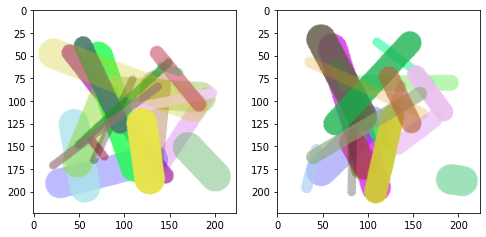

In [ ]:
# Run this cell multiple times to get different random samples + prediction

X, y = next(iter(train_dataloader))
#print(X.shape, y.shape)

#print(X[0][:3].permute(1,2,0).shape)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(X[0][:3].permute(1,2,0).cpu())
axs[1].imshow(X[0][3:6].permute(1,2,0).cpu())
print(y[0])
#print(model_ft(X)[0])

print("Real:", y[0], "Predicted:", diffusion_distance(X)[0].item())

## 4. Painting images through iterative optimization

### Some utility functions / losses

In [ ]:
def gradient_loss(gen_frames, gt_frames, alpha=1):
    """Gradient loss: MAE image gradients (i.e. edges of images)."""
    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy

    resize = torchvision.transforms.Resize(64)
    gen_frames = resize(gen_frames)
    gt_frames = resize(gt_frames)

    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    gt_dx, gt_dy = gradient(gt_frames)

    #blur = torchvision.transforms.GaussianBlur(9, sigma=(10))

    #show_img((torch.abs(gen_dx)+torch.abs(gen_dy)).squeeze().detach().cpu()) # decide which is best here. also blurring?
    #show_img(blur(torch.abs(gen_dx)+torch.abs(gen_dy)).squeeze().detach().cpu())
    
    # blurred edges - there is some bug in this code
    #gen_grad = torch.abs(gen_dx) + torch.abs(gen_dy)
    #gt_grad = torch.abs(gt_dx) + torch.abs(gt_dy)
    #gt_grad = blur(gt_grad)
    #gen_grad = blur(gen_grad)

    #return(torch.mean(torch.abs(gt_grad - gen_grad)))
    
    #grad_diff_x = torch.abs(blur(gt_dx) - blur(gen_dx))
    #grad_diff_y = torch.abs(blur(gt_dy) - blur(gen_dy))
        
    grad_diff_x = torch.abs((gt_dx) - (gen_dx))
    grad_diff_y = torch.abs((gt_dy) - (gen_dy))


    # condense into one tensor and avg
    return torch.mean(grad_diff_x ** alpha + grad_diff_y ** alpha)



In [ ]:
def angle_loss(shapes, canvas_size = 224, sigma = 20):
  """Angle loss. High loss value if angles of neighboring strokes are different (i.e. low if strokes are parallel).
  Very slow for large numbers of strokes.
  sigma = pixel size of neighborhood"""
  loss = torch.tensor(0.0).to(device)
  max_distance = torch.linalg.vector_norm(torch.tensor([canvas_size, canvas_size], dtype = torch.float))

  for p1 in range(len(shapes)):
    path_1 = shapes[p1]
    for i in range(path_1.points.shape[0] - 1):
      direction_1 = torch.nn.functional.normalize(path_1.points[i] - path_1.points[i+1], dim=0)
      middle_1 = (path_1.points[i] + path_1.points[i+1]) / 2

      for p2 in range(p1 + 1, len(shapes)):
        path_2 = shapes[p2]
        for j in range(path_2.points.shape[0] - 1):
          middle_2 = (path_2.points[j] + path_2.points[j+1]) / 2
          distance = torch.abs(torch.linalg.vector_norm(middle_1 - middle_2))
          weight = torch.exp(-(distance / (0.5*sigma))**2)
          if weight.item() < 0.05: # skips small weights for performance reasons
            pass
          else:
            direction_2 = torch.nn.functional.normalize(path_2.points[j] - path_2.points[j+1], dim=0)
            angle = 1 - torch.abs(torch.dot(direction_1, direction_2)) # not really the "angle" ...
            loss += angle * weight

  return loss / (len(shapes) * (len(shapes)-1) / 2 ) # normalize such that it can never be more than 1
#print(orientation_loss(shapes))

### Hyperparameters!
Play around with these to get different paintings

In [ ]:
# Setup
%cd /content/diffvg/apps/

# These arguments do not vary between layers

random.seed(1234)
torch.manual_seed(1234)

# canvas size for optimization. This has to match the input to the loss functions (e.g. trained neural nets)
canvas_width = canvas_height = 224 # ResNet expects 224px

output_size = 2000 # pixel size for final rendered image (square image)

# target image to be painted
# Image will be resized to be square. Do not use .png images with transparency
target_image_path = "/content/line3.jpg"

# In case of CLIP loss, choose text prompt
prompt = "A balloon flying in the sky HD"
neg_prompt = "A badly drawn sketch."
neg_prompt_2 = "Many ugly, messy drawings."
use_negative = False # Use negative prompts

# background for final rendering, currently white
background_output = torch.ones(output_size, output_size,4)
# background during optimization
background = torch.ones(224,224,4) # background image of first layer, currently white


lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').to(device) # you can use 'alex' or 'vgg' as well


# The values of these arguments can vary layer by layer.
# for example: num_paths = [50, 100, 150] -> Paint first layer with 50 strokes, second with 100 strokes, third with 150 strokes
# the list size has to match the "num_layers" argument.
# Lists of size 1 can be used as well, in this case, the same value is used for all layers.
# e.g. num_layers = 2, num_paths = [100] -> Two layers with 100 strokes each

num_layers = 1 # select number of layers (usually between 1 and 4) 

layer_args = dict(
  # Choose loss functions. Weight = 0.0 means that the loss is not calculated.
  Parameter_distance_weight = [0.0], # custom trained distance
  L1_weight = [1.0], # L1 / MAE
  L2_weight = [0.0], # L2 / MSE
  LPIPS_weight = [0.0], # Perceptual
  CLIP_weight = [0.0], # Text-similarity
  edge_weight = [0.0], # gradient / edges similarity 
  SSIM_weight = [0.0], # structural similarity
  orientation_weight = [0.0], # match stroke orientation (slow)
  

  curved_strokes = [False], # wheter to use curved or straight strokes

  # ARGUMENTS. Feel free to play around with these, especially num_paths.
  num_paths = [2], # number of strokes (i.e. paths)
  num_iter = [1000], # number of iterations for optimization
  max_width = [100], # maximum, minimum and initial stoke widths
  min_width = [2], 
  init_width = [10], 
  stroke_length = [0.5], # lengths for initializing strokes

  # optimizer learning rates:
  color_lr = [0.01],
  points_lr = [1.0],
  widths_lr = [0.1],
)


/content/diffvg/apps


### Setup

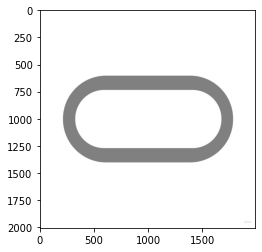

In [ ]:
num_augs = 16

# make sure all arguments have the right shape
for arg in layer_args.values():
  if len(arg) == 1:
    arg *= num_layers
  elif len(arg) != num_layers:
    raise ValueError('Number of arguments does not match number of layers')

# extract parameters from dict
Parameter_distance_weight = layer_args["Parameter_distance_weight"]
L1_weight = layer_args["L1_weight"]
L2_weight = layer_args["L2_weight"]
LPIPS_weight = layer_args["LPIPS_weight"]
CLIP_weight = layer_args["CLIP_weight"]
edge_weight = layer_args["edge_weight"]
curved_strokes = layer_args["curved_strokes"]
num_paths = layer_args["num_paths"]
num_iter = layer_args["num_iter"]
max_width = layer_args["max_width"] 
min_width = layer_args["min_width"]
init_width = layer_args["init_width"]
stroke_length = layer_args["stroke_length"]
color_lr = layer_args["color_lr"]
points_lr = layer_args["points_lr"]
widths_lr = layer_args["widths_lr"]
SSIM_weight = layer_args["SSIM_weight"]
orientation_weight = layer_args["orientation_weight"]
#tmp_weight = layer_args["tmp_weight"]
tmp_weight = LPIPS_weight

# display target image to check if everything is correct
target = torchvision.io.read_image(target_image_path)
plt.imshow(target.cpu().permute(1,2,0))
resize = torchvision.transforms.Resize([224,224])
target_resized = resize(target)
target_reshaped = target_resized.unsqueeze(0).to(device)
target = target_reshaped / 255

if model_ft:
  model_ft.eval()

pydiffvg.set_print_timing(False)

# gamma value for diffvg
gamma = 1.0

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())
device = torch.device('cuda')
pydiffvg.set_device(device)

# Image Augmentation Transformation
augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(canvas_width, scale=(0.7,0.9)),
])


if sum(map(abs, CLIP_weight)) > 0.0:
  text_input = clip.tokenize(prompt).to(device)
  text_input_neg1 = clip.tokenize(neg_prompt).to(device)
  text_input_neg2 = clip.tokenize(neg_prompt_2).to(device)

    # Calculate features
  with torch.no_grad():
      text_features = model.encode_text(text_input)
      text_features_neg1 = model.encode_text(text_input_neg1)
      text_features_neg2 = model.encode_text(text_input_neg2)

# Thanks to Katherine Crowson for this. 
# In the CLIPDraw code used to generate examples, we don't normalize images
# before passing into CLIP, but really you should. Turn this to True to do that.
use_normalized_clip = True

if use_normalized_clip:
    augment_trans_clip = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])
    

# list of layers where rendered images will be saved
img_layers = [background] # low res
img_layers_high = [background_output] # high res
layers = []

# history of losses for plotting
L1_hist = []
L2_hist = []
param_hist = []
clip_hist = []
edge_hist = []
orientation_hist = []
SSIM_hist = []
tmp_hist = []

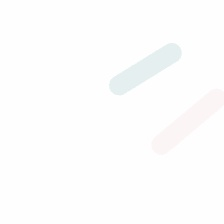

render loss: 0.06791667640209198
 l1:  0.06791667640209198 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 0



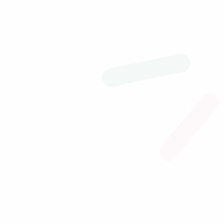

render loss: 0.06707517802715302
 l1:  0.06707517802715302 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 10



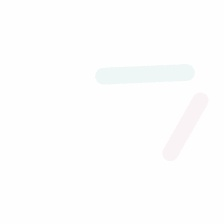

render loss: 0.0663975328207016
 l1:  0.0663975328207016 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 20



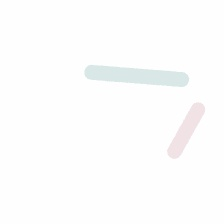

render loss: 0.06404774636030197
 l1:  0.06404774636030197 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 30



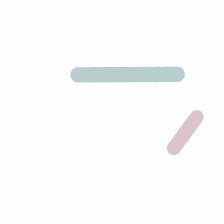

render loss: 0.05924532935023308
 l1:  0.05924532935023308 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 40



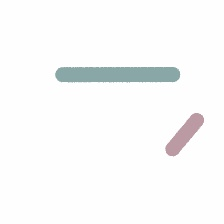

render loss: 0.05147812142968178
 l1:  0.05147812142968178 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 50



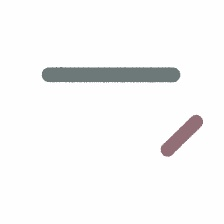

render loss: 0.04760412499308586
 l1:  0.04760412499308586 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 60



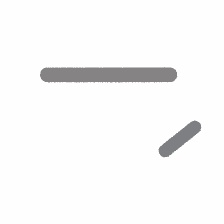

render loss: 0.046133242547512054
 l1:  0.046133242547512054 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 70



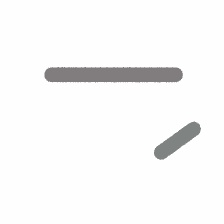

render loss: 0.045525141060352325
 l1:  0.045525141060352325 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 80



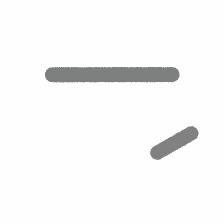

render loss: 0.0453001894056797
 l1:  0.0453001894056797 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 90



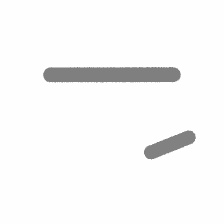

render loss: 0.04471518471837044
 l1:  0.04471518471837044 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 100



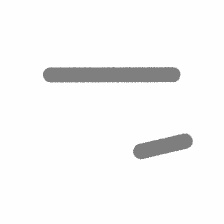

render loss: 0.044033508747816086
 l1:  0.044033508747816086 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 110



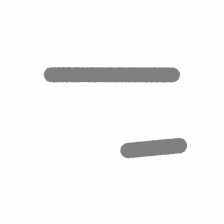

render loss: 0.04252634570002556
 l1:  0.04252634570002556 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 120



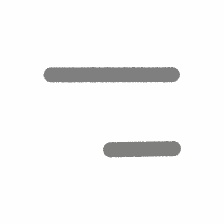

render loss: 0.040125612169504166
 l1:  0.040125612169504166 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 130



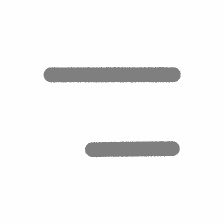

render loss: 0.03764434531331062
 l1:  0.03764434531331062 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 140



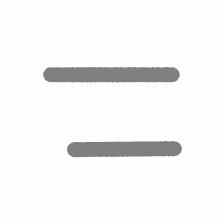

render loss: 0.03509770706295967
 l1:  0.03509770706295967 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 150



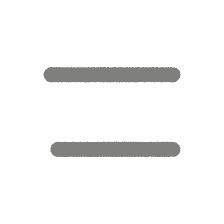

render loss: 0.032869912683963776
 l1:  0.032869912683963776 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 160



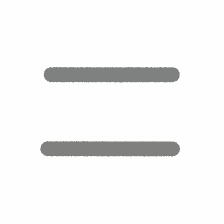

render loss: 0.03338645026087761
 l1:  0.03338645026087761 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 170



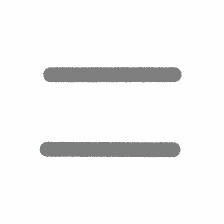

render loss: 0.03285795822739601
 l1:  0.03285795822739601 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 180



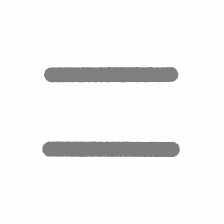

render loss: 0.03270890191197395
 l1:  0.03270890191197395 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 190



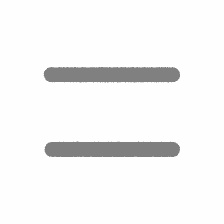

render loss: 0.03257690370082855
 l1:  0.03257690370082855 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 200



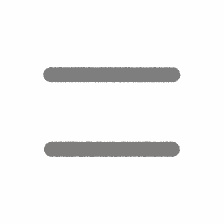

render loss: 0.03272275999188423
 l1:  0.03272275999188423 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 210



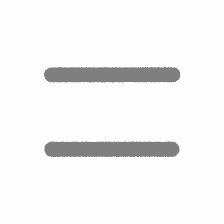

render loss: 0.03267071023583412
 l1:  0.03267071023583412 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 220



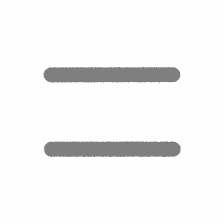

render loss: 0.03279856592416763
 l1:  0.03279856592416763 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 230



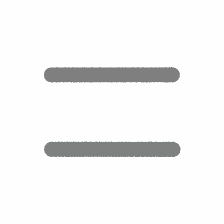

render loss: 0.032645635306835175
 l1:  0.032645635306835175 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 240



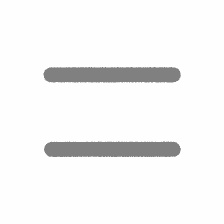

render loss: 0.03272988274693489
 l1:  0.03272988274693489 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 250



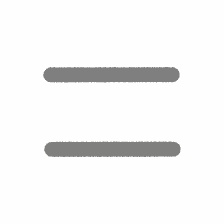

render loss: 0.03269415721297264
 l1:  0.03269415721297264 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 260



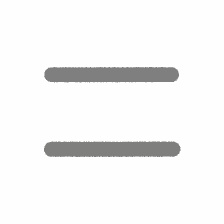

render loss: 0.032654982060194016
 l1:  0.032654982060194016 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 270



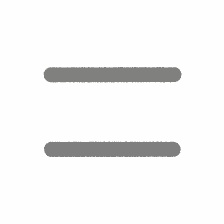

render loss: 0.03261301666498184
 l1:  0.03261301666498184 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 280



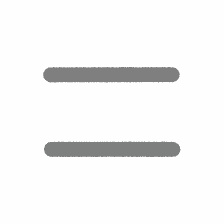

render loss: 0.03260662034153938
 l1:  0.03260662034153938 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 290



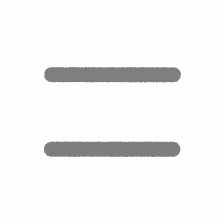

render loss: 0.03276250883936882
 l1:  0.03276250883936882 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 300



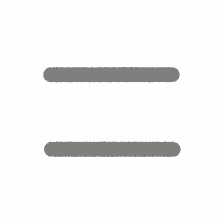

render loss: 0.03257528692483902
 l1:  0.03257528692483902 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 310



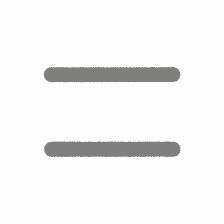

render loss: 0.03264781832695007
 l1:  0.03264781832695007 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 320



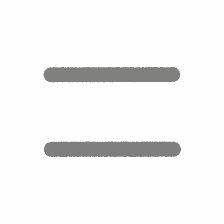

render loss: 0.032674629241228104
 l1:  0.032674629241228104 
 l2:  0.0 
 param:  0.0 
 clip: 0.0 
 edge: 0.0 
 orientation: 0.0 
 SSIM: 0.0 
 TMP: 0.0
iteration: 330



KeyboardInterrupt: ignored

In [ ]:
#@title Curve Optimizer {vertical-output: true}

for layer_index in range(num_layers):

  # Initialize Random Curves for current layer
  shapes = []
  shape_groups = []
  for i in range(num_paths[layer_index]):

    if curved_strokes[layer_index]:
      num_segments = 1 #random.randint(1, 3)
      num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
      points = []
      p0 = (random.random(), random.random())
      points.append(p0)
      for j in range(num_segments):
          radius = stroke_length[layer_index]
          p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
          p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
          p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
          points.append(p1)
          points.append(p2)
          points.append(p3)
          p0 = p3

    else: # lines instead of strokes
      num_segments = 1 #random.randint(1, 3)
      num_control_points = torch.tensor((0,0))
      points = []
      p0 = (random.random(), random.random())
      points.append(p0)
      for j in range(num_segments):
          radius = stroke_length[layer_index]
          p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
          points.append(p1)

    points = torch.tensor(points)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height
    path = pydiffvg.Path(num_control_points = num_control_points, points = points, stroke_width = torch.tensor(init_width[layer_index], dtype=torch.float64), is_closed = False)
    shapes.append(path)
    path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]), fill_color = None, stroke_color = torch.tensor([random.random(), random.random(), random.random(), random.random()]))
    shape_groups.append(path_group)


  # Just some diffvg setup
  scene_args = pydiffvg.RenderFunction.serialize_scene(\
      canvas_width, canvas_height, shapes, shape_groups)
  render = pydiffvg.RenderFunction.apply
  img = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)
  points_vars = []
  stroke_width_vars = []
  color_vars = []
  for path in shapes:
      path.points.requires_grad = True
      points_vars.append(path.points)
      path.stroke_width.requires_grad = True
      stroke_width_vars.append(path.stroke_width)
  for group in shape_groups:
      group.stroke_color.requires_grad = True
      color_vars.append(group.stroke_color)

  # Optimizers
  points_optim = torch.optim.Adam(points_vars, points_lr[layer_index])
  width_optim = torch.optim.Adam(stroke_width_vars, widths_lr[layer_index])
  color_optim = torch.optim.Adam(color_vars, color_lr[layer_index])

  # Run the main optimization loop
  for t in range(num_iter[layer_index]):

      # Anneal learning rate (makes videos look cleaner)
      #anneal_lr = True
      #if anneal_lr:
      #  if t == int(args.num_iter[layer_index] * 0.5):
      #    for g in points_optim.param_groups:
      #        g['lr'] = 0.4
      #  if t == int(args.num_iter[layer_index] * 0.75):
      #    for g in points_optim.param_groups:
      #        g['lr'] = 0.1
      
      points_optim.zero_grad()
      width_optim.zero_grad()
      color_optim.zero_grad()
      scene_args = pydiffvg.RenderFunction.serialize_scene(\
          canvas_width, canvas_height, shapes, shape_groups)
      #print(img_layers[layer].shape)

      # low resolution render for optimization
      img = render(canvas_width, canvas_height, 2, 2, t, img_layers[layer_index], *scene_args)
      img_copy = img.detach().clone() # copy layer to use as background later
      img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4]) #remove alpha channel
      if t % 5 == 0:
          pydiffvg.imwrite(img.cpu(), '/content/res/iter_{}.png'.format(int(t/5)), gamma=gamma)
      img = img[:, :, :3]
      img = img.unsqueeze(0)
      img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
      
      # Initialize losses
      L1_loss = torch.tensor(0.0).to(device)
      L2_loss = torch.tensor(0.0).to(device)
      parameter_loss = torch.tensor(0.0).to(device)
      CLIP_loss = torch.tensor(0.0).to(device)
      edge_loss = torch.tensor(0.0).to(device)
      SSIM_loss = torch.tensor(0.0).to(device)
      orientation_loss = torch.tensor(0.0).to(device)
      tmp_loss = torch.tensor(0.0).to(device)

      # CLIP similarity / loss
      if CLIP_weight[layer_index] != 0.0:
        img_augs = []
        for n in range(num_augs):
            img_augs.append(augment_trans_clip(img))
        im_batch = torch.cat(img_augs)
        image_features = model.encode_image(im_batch)
        for n in range(num_augs):
            CLIP_loss -= torch.cosine_similarity(text_features, image_features[n:n+1], dim=1).squeeze() * CLIP_weight[layer_index] * (1/num_augs)
            if use_negative:
                CLIP_loss += torch.cosine_similarity(text_features_neg1, image_features[n:n+1], dim=1).squeeze() * 0.3 * CLIP_weight[layer_index] * (1/num_augs)
                CLIP_loss += torch.cosine_similarity(text_features_neg2, image_features[n:n+1], dim=1).squeeze() * 0.3 * CLIP_weight[layer_index] * (1/num_augs)
        
      # L1 loss
      if L1_weight[layer_index] != 0.0:
        #L1_loss += torch.mean(torch.log((torch.abs(target - img) ** 1) +1)) * L1_weight[layer_index]
        L1_loss += torch.mean((torch.abs(target - img) + 0.01) ** 1) * L1_weight[layer_index]

      # L2 loss
      if L2_weight[layer_index] != 0.0:
        L1_loss += torch.mean(torch.log((torch.abs(target - img) ** 2) +1)) * L2_weight[layer_index]
      
      if orientation_weight[layer_index] != 0.0:#and t > 100 and t % 5 == 0: # very costly, only calculate every 5 iterations
        orientation_loss += angle_loss(shapes, canvas_size = 224, sigma = 30) * orientation_weight[layer_index]

      if SSIM_weight[layer_index] != 0.0:
        resize = torchvision.transforms.Resize(224)
        SSIM_loss += 1 - multiscale_structural_similarity_index_measure(resize(target) , resize(img), normalize = None, kernel_size=11) * SSIM_weight[layer_index]

      # edges loss
      if edge_weight[layer_index] != 0.0:
        edge_loss += gradient_loss(img, target) * edge_weight[layer_index]

      if tmp_weight[layer_index] != 0.0:
        tmp_loss += lpips(target, img) * tmp_weight[layer_index]
        
      # Parameter distance loss
      # target and current canvas are joined together to ensure that they get the same exact augemntation
      if Parameter_distance_weight[layer_index] != 0.0:  
        img_and_target = torch.cat([img, target], dim = 1)
        img_target_augs = []
        for n in range(num_augs):
            img_target_augs.append(augment_trans(img_and_target))
        im_target_batch = torch.cat(img_target_augs)

        canvas_embedding = model_ft(im_target_batch[:,0:3,:,:])
        target_embedding = model_ft(im_target_batch[:,3:6,:,:])
        embedding_distances = torch.sum((canvas_embedding - target_embedding)**2, dim=1)
        parameter_loss = torch.log(torch.mean(embedding_distances) * Parameter_distance_weight[layer_index] + 1) # sum over augment batch

      # Sum up all the losses
      loss = L1_loss + L2_loss + parameter_loss + CLIP_loss + edge_loss + SSIM_loss + orientation_loss + tmp_loss

      # Backpropagate the gradients.
      loss.backward()

      L1_hist.append(L1_loss.detach().cpu().item())
      L2_hist.append(L2_loss.detach().cpu().item())
      param_hist.append(parameter_loss.detach().cpu().item())
      clip_hist.append(CLIP_loss.detach().cpu().item())
      edge_hist.append(edge_loss.detach().cpu().item())
      orientation_hist.append(orientation_loss.detach().cpu().item())
      tmp_hist.append(tmp_loss.detach().cpu().item())
      SSIM_hist.append(SSIM_loss.detach().cpu().item())


      # Take a gradient descent step.
      points_optim.step()
      width_optim.step()
      color_optim.step()
      for path in shapes:
          path.stroke_width.data.clamp_(min_width[layer_index], max_width[layer_index])
      for group in shape_groups:
          group.stroke_color.data.clamp_(0.05, 0.95)
          #group.stroke_color.data.clamp_(0.0, 1.0)

      if t % 10 == 0:
          show_img(img.detach().cpu().numpy()[0])
          # show_img(torch.cat([img.detach(), img_aug.detach()], axis=3).cpu().numpy()[0])
          print('render loss:', loss.item())
          print(" l1: ", L1_loss.item(), "\n l2: ", L2_loss.item(), "\n param: ", parameter_loss.item(), "\n clip:", CLIP_loss.item(), "\n edge:", edge_loss.item(), "\n orientation:", orientation_loss.item(), "\n SSIM:", SSIM_loss.item(), "\n TMP:",tmp_loss.item())
          print('iteration:', t)
          print()
          #with torch.no_grad():
          #    im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
          #    noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
          #    similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
          #    values, indices = similarity[0].topk(5)
          #    print("\nTop predictions:\n")
          #    for value, index in zip(values, indices):
          #        print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")
  
  img_layers.append(img_copy)

  # high resolution image for nice rendering
  img_high_res = render(output_size, output_size, 4, 4, t, img_layers_high[layer_index], *scene_args)
  img_layers_high.append(img_high_res.detach().clone())

  layers.append(render(output_size, output_size, 4, 4, t, None, *scene_args).detach().clone())


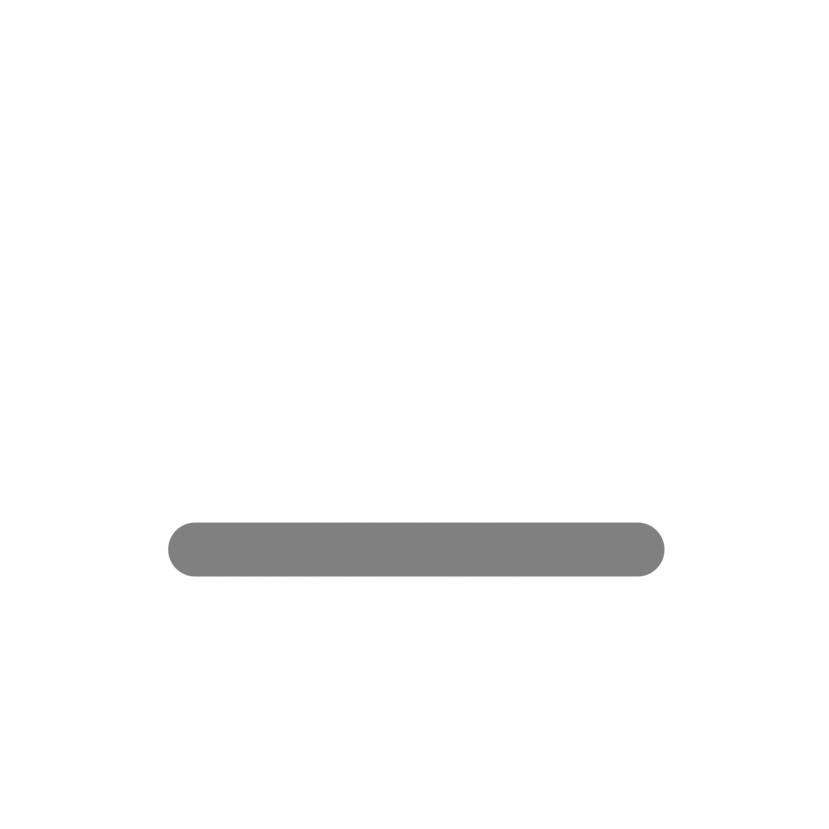

In [ ]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(img_layers_high[num_layers].cpu())

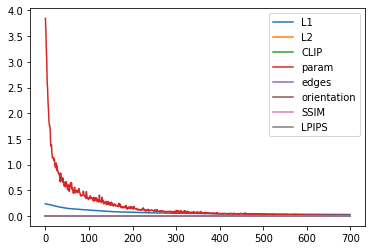

In [ ]:
# show optimization progress
# unused losses are zero

plt.plot(L1_hist)
plt.plot(L2_hist)
plt.plot(clip_hist)
plt.plot(param_hist)
plt.plot(edge_hist)
plt.plot(orientation_hist)
plt.plot(SSIM_hist)
plt.plot(tmp_hist)
plt.legend(["L1", "L2", "CLIP", "param", "edges", "orientation", "SSIM", "LPIPS"])
